In [18]:
import pandas as pd
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader,Dataset
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import transforms
from torch.optim import Adam

In [19]:
df= pd.read_csv('trainLabels.csv')
df['filename'] = df['id'].astype(str) + '.png'
train_df=df[df['filename'].isin(os.listdir('./train/'))].reset_index(drop=True)
train_df['image_path'] = './train/' +train_df['filename']
train_df = train_df.drop(columns=['id','filename'])
train_df.head(2)

,label,image_path
0,frog,./train/1.png
1,truck,./train/2.png


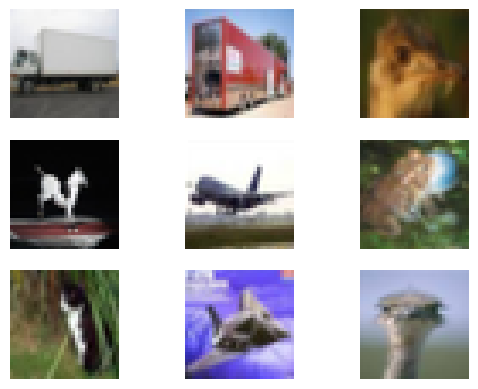

In [20]:
n_row = 3
n_col=3
f,axs = plt.subplots(n_row,n_col)

for c in range(n_col):
    for r in range(n_row):
        img = Image.open(train_df.sample(1)['image_path'].item()).convert('RGB')
        axs[c,r].imshow(img)
        axs[c,r].axis('off')
        plt.show

In [21]:
X_train,X_temp,Y_train,Y_temp = train_test_split(train_df['image_path'],train_df.label,shuffle=True,test_size=.2)
X_test,X_val,Y_test,Y_val = train_test_split(X_temp,Y_temp,stratify=Y_temp,shuffle=True,test_size=.5)

In [22]:
labelencoder = LabelEncoder()
labelencoder.fit(train_df['label'])

LabelEncoder()

In [23]:
NORM_MEAN = (0.485, 0.456, 0.406)
NORM_STD = (0.229, 0.224, 0.225)

transforms_train = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(
        degrees=20,translate=(.1,.1),scale=(.8,1.2),shear=10
    ),
    transforms.ColorJitter(brightness=.2,contrast=.2,saturation=.2),
    transforms.ToTensor(),
    transforms.Normalize(NORM_MEAN,NORM_STD)]
)
transform =  transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(NORM_MEAN,NORM_STD)]
)



In [24]:
class CustomDataSet(Dataset):
    def __init__(self,X,Y,transforms=None):
        super().__init__()
        self.X=X
        self.Y = torch.tensor(labelencoder.transform(Y),dtype=torch.long)
        self.transforms = transforms
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,index):
        img_path = self.X[index]
        image = Image.open(img_path).convert('RGB')
        
        if self.transforms:
            image = self.transforms(image)
            return image,self.Y[index]
        
        return image,self.Y[index]

In [25]:
train_df.label.nunique()

10

In [26]:
class MyModule(nn.Module):
    def __init__(self,input_dim=3):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Conv2d(input_dim,32,kernel_size=3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            # nn.Conv2d(128,256,kernel_size=3,padding=1),
            # nn.BatchNorm2d(256),
            # nn.ReLU(),
            # nn.MaxPool2d(2,2),


            nn.Flatten(),
            nn.Linear((128*4*4),512),
            nn.ReLU(),
            nn.Dropout(.3),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Dropout(.3),
            nn.Linear(256,train_df.label.nunique())


        )
    def forward(self,x):
        x = self.sequential(x)
        return x

In [27]:
train_dataset = CustomDataSet(X_train.tolist(),Y_train.tolist(),transforms_train)
val_dataset = CustomDataSet(X_val.tolist(),Y_val,transform)
test_dataset = CustomDataSet(X_test.tolist(),Y_test,transform)

In [28]:
X_train,Y_train

(16622    ./train/16623.png
 21900    ./train/21901.png
 26857    ./train/26858.png
 1113      ./train/1114.png
 17926    ./train/17927.png
                ...        
 35726    ./train/35727.png
 6688      ./train/6689.png
 35306    ./train/35307.png
 10595    ./train/10596.png
 38844    ./train/38845.png
 Name: image_path, Length: 40000, dtype: object,
 16622        bird
 21900        bird
 26857         dog
 1113        horse
 17926         cat
            ...   
 35726        ship
 6688     airplane
 35306        bird
 10595         cat
 38844        frog
 Name: label, Length: 40000, dtype: object)

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [30]:
BATCH_SIZE = 64
EPOCHS =20
LR =5e-4 
WEIGHT_DECAY=1e-4
model = MyModule().to(device)

In [31]:
from torchsummary import summary
summary(model,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
      BatchNorm2d-10            [-1, 128, 8, 8]             256
             ReLU-11            [-1, 128, 8, 8]               0
        MaxPool2d-12            [-1, 128, 4, 4]               0
          Flatten-13                 [-1, 2048]               0
           Linear-14                  [

In [32]:
train_dataloader= DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_dataloader= DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False)
test_dataloader= DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer =  Adam(model.parameters(),lr=LR,weight_decay=WEIGHT_DECAY)

In [34]:
total_train_loss_plot = []
total_train_acc_plot = []
total_validation_acc_plot=[]
total_validation_loss_plot=[]
best_val_acc = 0
for epoch in range(EPOCHS):
    total_train_loss = 0
    total_train_acc = 0
    
    model.train()
    
    for img,label in tqdm(train_dataloader,desc='Training'):
        img,label = img.to(device),label.to(device)
        optimizer.zero_grad()
        outputs = model(img)
        loss = criterion(outputs,label)
        loss.backward()

        # if model.sequential[0].weight.grad is not None:
        #     print(f" (Debug Grad Mean: {model.sequential[0].weight.grad.abs().mean().item():.6f})")
        # else:
        #     print("not learning")

        optimizer.step()
        
        total_train_loss+= loss.item() * img.size(0)
        train_acc = (torch.argmax(outputs,axis=1)==label).sum().item()
        total_train_acc +=train_acc
        
    avg_train_acc = total_train_acc/len(train_dataset)
    avg_train_loss = total_train_loss/len(train_dataset)
    total_train_loss_plot.append(round(avg_train_loss,2))
    total_train_acc_plot.append(round(avg_train_acc*100,2))      
    
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        total_val_acc = 0 
        for img,label in val_dataloader:
            img,label = img.to(device),label.to(device)
            outputs = model(img)
            loss = criterion(outputs,label)
            
            total_val_loss += loss.item() * img.size(0)
            val_acc = (torch.argmax(outputs,axis=1)==label).sum().item()
            total_val_acc +=val_acc
            
        avg_val_acc = total_val_acc / len(val_dataset)
        avg_val_loss = total_val_loss/len(val_dataset)
        total_validation_loss_plot.append(round(avg_val_loss,2))
        total_validation_acc_plot.append(round(avg_val_acc*100,2))
        
        if epoch % 5 == 0 :
            print(f"Epoch:{epoch+1}/{EPOCHS} Train loss: {total_train_loss_plot[epoch]} Train accuracy: {total_train_acc_plot[epoch]}%")
            print(f"Epoch:{epoch+1}/{EPOCHS} Val loss: {total_validation_loss_plot[epoch]} Val accuracy: {total_validation_acc_plot[epoch]}%")
            
        if avg_val_acc > best_val_acc :
            best_val_acc=avg_val_acc
            torch.save(model.state_dict(),'best_model_CIFAR.pth')
            print(f'Model saved with avg val of {avg_val_acc*100}%')
            
        
            

Training: 100%|██████████| 625/625 [00:40<00:00, 15.34it/s]


Epoch:1/20 Train loss: 1.64 Train accuracy: 39.05%
Epoch:1/20 Val loss: 1.39 Val accuracy: 48.48%
Model saved with avg val of 48.480000000000004%


Training: 100%|██████████| 625/625 [00:38<00:00, 16.20it/s]


Model saved with avg val of 56.24%


Training: 100%|██████████| 625/625 [00:40<00:00, 15.42it/s]


Model saved with avg val of 63.85999999999999%


Training: 100%|██████████| 625/625 [00:37<00:00, 16.56it/s]


Model saved with avg val of 66.2%


Training: 100%|██████████| 625/625 [00:38<00:00, 16.08it/s]


Model saved with avg val of 67.75999999999999%


Training: 100%|██████████| 625/625 [00:39<00:00, 15.98it/s]


Epoch:6/20 Train loss: 1.06 Train accuracy: 62.66%
Epoch:6/20 Val loss: 0.86 Val accuracy: 69.58%
Model saved with avg val of 69.58%


Training: 100%|██████████| 625/625 [00:40<00:00, 15.33it/s]


Model saved with avg val of 71.12%


Training: 100%|██████████| 625/625 [00:38<00:00, 16.34it/s]


Model saved with avg val of 72.26%


Training: 100%|██████████| 625/625 [00:37<00:00, 16.56it/s]


Model saved with avg val of 72.34%


Training: 100%|██████████| 625/625 [00:37<00:00, 16.61it/s]


Model saved with avg val of 75.53999999999999%


Training: 100%|██████████| 625/625 [00:42<00:00, 14.82it/s]


Epoch:11/20 Train loss: 0.92 Train accuracy: 68.01%
Epoch:11/20 Val loss: 0.73 Val accuracy: 74.64%


Training: 100%|██████████| 625/625 [00:39<00:00, 15.96it/s]


Model saved with avg val of 76.22%


Training: 100%|██████████| 625/625 [00:38<00:00, 16.06it/s]


Model saved with avg val of 77.53999999999999%


Training: 100%|██████████| 625/625 [00:39<00:00, 15.94it/s]


Model saved with avg val of 77.66%


Training: 100%|██████████| 625/625 [00:38<00:00, 16.36it/s]


Epoch:16/20 Train loss: 0.83 Train accuracy: 70.8%
Epoch:16/20 Val loss: 0.67 Val accuracy: 76.82%


Training: 100%|██████████| 625/625 [00:39<00:00, 15.94it/s]


Model saved with avg val of 78.12%


Training: 100%|██████████| 625/625 [00:40<00:00, 15.57it/s]


Model saved with avg val of 78.48%


In [35]:
from sklearn.metrics import classification_report

In [36]:
model.eval()
all_preds = []
all_labels = []
total_test_acc =0
total_test_loss =0 
with torch.no_grad():
    for images,label in test_dataloader:
        images,label = images.to(device),label.to(device)
        outputs = model(images)
        loss = criterion(outputs,label)
        total_test_loss += loss.item() * images.size(0)
        prediction = torch.argmax(outputs,1)
        total_test_acc += (prediction==label).sum().item()

        all_preds.extend(prediction.cpu().numpy())
        all_labels.extend(label.cpu().numpy())
        
        avg_test_acc = total_test_acc / len(test_dataset)
        avg_test_loss = total_test_loss / len(test_dataset)
        
    print(f"Test loss: {avg_test_loss*100:.2f} Test accuracy: {avg_test_acc*100:.2f}%")
    print(classification_report(all_labels,all_preds))

Test loss: 62.44 Test accuracy: 78.50%
              precision    recall  f1-score   support

           0       0.84      0.83      0.83       499
           1       0.82      0.94      0.87       485
           2       0.66      0.76      0.71       469
           3       0.64      0.59      0.62       493
           4       0.79      0.71      0.75       532
           5       0.81      0.57      0.67       509
           6       0.87      0.82      0.84       485
           7       0.69      0.88      0.77       499
           8       0.88      0.90      0.89       526
           9       0.87      0.85      0.86       503

    accuracy                           0.79      5000
   macro avg       0.79      0.79      0.78      5000
weighted avg       0.79      0.79      0.78      5000



In [37]:
import joblib
joblib.dump(labelencoder,'labelencoder.joblib')

['labelencoder.joblib']